## Assignment: Fingerprint & UiA Image Matching with OpenCV

__Course: IKT213 Machine Vision__\
__Author: Maximilian Eckstein__\
__Date: 22.09.2025__

This project implements and evaluates two classical feature-based matching pipelines—**SIFT** and **ORB**—for two domains:
1) **Fingerprint images** (following and adapting the OpenCV blog tutorial “Fingerprint Matching using OpenCV”), and  
2) **UiA images** (logo/photo variants).

We will use the provided `data_check` samples for both domains, log performance for each pipeline, and **compare speed, resource usage, and accuracy**. The final section of this notebook presents a side-by-side interpretation of both methods on both datasets.

**Tutorial basis.** OpenCV blog: *“Fingerprint Matching using OpenCV”* (used for conceptual guidance and baseline procedures).

**Attribution.** This notebook was developed with assistance from **ChatGPT (GPT-5 Thinking)** for:
- Understanding and adapting the example code  
- Writing function descriptions and inline comments  
- Adjusting the `process_data` functions for both domains  
- Measuring performance and collecting metrics  
- Storing performance logs to CSV files (e.g., `SIFT_perf_log.csv`, `ORB_perf_log.csv`)

> Note: The core SIFT and ORB pipelines remain as described in the OpenCV tutorial,  
but some preprocessing parameters (e.g., blurring before grayscale conversion)  
were adjusted to better fit the fingerprint and UiA datasets.  
The main focus is on structuring the workflow, adding documentation,  
and interpreting the results.*

In [1]:
# --- Setup and Imports ---

import cv2
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from time import perf_counter, process_time

data_path_UiA = r"data\data_UiA"
data_path_samples = r"data\data_check"
orb_results_path = r"results\orb_results"
sift_results_path = r"results\sift_results"

### Methode 1: ORB Feature Detection & Matching

The first pipeline uses **ORB (Oriented FAST and Rotated BRIEF)**,  
a fast and efficient feature detector and descriptor that is free of licensing restrictions.  
It is widely used when speed and low computational cost are critical,  
making it a good baseline for comparison against the more computationally expensive SIFT.

**General ORB workflow:**
1. Preprocess the image (optional: resize, blur, convert to grayscale).
2. Detect keypoints and compute binary descriptors using ORB.
3. Match descriptors with a Hamming distance-based matcher (e.g., `cv2.BFMatcher` with `NORM_HAMMING`).
4. Apply a filtering step (e.g., ratio test) to remove poor matches.
5. Count good matches and estimate whether two images are similar.

**Why ORB here?**
- Very **fast** on CPU-only execution.
- Requires **fewer resources** compared to SIFT.
- Often sufficient for structured patterns like logos or clear fingerprint ridges.
- May, however, yield **lower accuracy** than SIFT in complex or noisy datasets.

We will now implement the ORB pipeline, including timing and logging,  
to compare it later with SIFT in terms of CPU speed and matching robustness.

In [2]:
# --- Adjustable parameters ---

ORB_NFEATURES = 1000          # ADJUSTABLE: number of maximum ORB keypoints to detect
RATIO_TEST = 0.75             # ADJUSTABLE: Lowe's ratio threshold (typical 0.6–0.85)
MATCH_THRESHOLD = 24          # ADJUSTABLE: decision threshold on #good matches for "same" vs "different"
BLUR_BEFORE_THRESHOLD = False # ADJUSTABLE: slight blur stabilizes Otsu on noisy images
BLUR_KERNEL = (3, 3)          # ADJUSTABLE: kernel size for Gaussian blur
BF_CROSS_CHECK = False        # (NOT) ADJUSTABLE: False for KNN + ratio-test, True for simple BF matching
KNN_K = 2                     # (NOT) ADJUSTABLE: number of nearest neighbors (2 needed for ratio test)

In [3]:
# ============================================================
# ORB PIPELINE: Feature detection, description & matching
# ============================================================

def preprocess_image_orb(image_path):
    """
    Read an image and convert it to a clean binary image for feature extraction.

    Parameters
    ----------
    image_path : str
        Path to the input image.

    Returns
    -------
    img_bin : np.ndarray
        Binary (black/white) image used for feature detection.
    """
    # --- Load as grayscale (single channel) ---
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    
    # --- Optional: blur before thresholding to stabilize Otsu on noisy inputs ---
    # Controlled via global flags/params: BLUR_BEFORE_THRESHOLD, BLUR_KERNEL
    if BLUR_BEFORE_THRESHOLD:
        img = cv2.GaussianBlur(img, BLUR_KERNEL, 0)  # ADJUSTABLE: kernel size
    
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img_bin  # return binary image

# ------------------------------------------------------------
# Pairwise comparison using ORB features
# ------------------------------------------------------------
def compare_images_orb(img1_path, img2_path):
    """
    Compare two images by ORB features and return the number of good matches and a visualization.

    Pipeline:
      1) Preprocess (grayscale -> threshold to binary).
      2) Detect ORB keypoints + descriptors.
      3) BFMatcher with Hamming distance, KNN (k=2).
      4) Lowe's ratio test to keep only unambiguous matches.
      5) Return the count of good matches and a drawn match image.

    Parameters
    ----------
    img1_path : str
        Path to the first image.
    img2_path : str
        Path to the second image.

    Returns
    -------
    match_count : int
        Number of "good" matches after the ratio test.
    match_img : np.ndarray or None
        Visualization image with matched keypoints drawn (None if nothing to draw).
    """
    # --- Preprocess both images (binary) ---
    img1 = preprocess_image_orb(img1_path)
    img2 = preprocess_image_orb(img2_path)
 
    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=ORB_NFEATURES)   # ADJUSTABLE: number of keypoints
 
    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0, None  # Return 0 matches if no descriptors found
 
    # Use Brute-Force Matcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=BF_CROSS_CHECK)  # (ADJUSTABLE): crossCheck True/False (False for KNN + ratio test)
 
    # KNN Match: for each descriptor in des1, get K best in des2
    matches = bf.knnMatch(des1, des2, k=KNN_K)  # (ADJUSTABLE): KNN_K must be 2 for ratio test
 
    # Lowe's ratio test to filter ambiguous matches
    good_matches = []
    for pair in matches:
        if len(pair) < 2:
            continue
        m, n = pair[0], pair[1]
        if m.distance < RATIO_TEST * n.distance:  # ADJUSTABLE
            good_matches.append(m)

    # Draw good matches for visualization (side-by-side)
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return len(good_matches), match_img

# ------------------------------------------------------------
# Batch processing over a labeled dataset
# ------------------------------------------------------------
def process_dataset_orb(dataset_path, results_folder):
    """
    Process a labeled dataset structured as:
        dataset_path/
        ├─ <folder_1>  # folder name contains 'same' or 'different'
        │   ├─ image_a.(tif|png|jpg)
        │   └─ image_b.(tif|png|jpg)
        ├─ <folder_2>
        └─ ...

    For each subfolder (must contain exactly 2 images), compare the two images,
    predict "same" (1) or "different" (0) based on the number of good matches,
    save the visualization, and finally plot the confusion matrix across ALL pairs.

    Additionally, this function records SIMPLE performance metrics for the entire
    end-to-end pipeline:
    - Per-pair wall time (seconds) via time.perf_counter()
    - Per-pair CPU time (seconds) via time.process_time()
    - Total/average wall & CPU times printed at the end

    A CSV log is written to:  <results_folder>/perf_log.csv
    with columns:
    folder, img1, img2, match_count, wall_time_s, cpu_time_s

    Parameters
    ----------
    dataset_path : str
        Root directory that contains labeled subfolders.
    results_folder : str
        Output directory for match visualization images and perf_log.csv.

    Returns
    -------
    None
        Displays a confusion matrix for ALL processed pairs and prints a short
        performance summary (totals and averages).

    Notes
    -----
    - The performance numbers cover the full pipeline per pair:
    load → preprocess → ORB detect/describe → BF KNN match → ratio test → (draw) → decision.
    - The CSV can be used to compute additional statistics outside this function.
    """

    # --- Decision threshold (global) for classifying "same" vs "different" ---
    threshold = MATCH_THRESHOLD  # ADJUSTABLE decision threshold
    y_true = []  # True labels (1 for same, 0 for different)
    y_pred = []  # Predicted labels
 
    # Ensure output directory exists
    os.makedirs(results_folder, exist_ok=True)

    # Performance logging setup (CSV)
    perf_csv = os.path.join(results_folder, "ORB_perf_log.csv")
    perf_rows = [("folder", "img1", "img2", "match_count",
                  "wall_time_s", "cpu_time_s")]
    
    # --- Total timers for overall runtime stats ---
    total_wall_start = perf_counter()
    total_cpu_start  = process_time()
 
    # Iterate over labeled subfolders
    for folder in sorted(os.listdir(dataset_path)):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a valid directory
            # Collect exactly two image files with supported extensions
            image_files = [
                f for f in os.listdir(folder_path)
                if os.path.splitext(f)[1].lower() in ('.tif', '.png', '.jpg', '.jpeg', '.bmp')
            ]
            if len(image_files) != 2:
                print(f"Skipping {folder}, expected 2 images but found {len(image_files)}")
                continue  # Skip if the folder doesn't have exactly 2 images

            image_files.sort()  # Sort to ensure consistent order
            img1_path = os.path.join(folder_path, image_files[0])
            img2_path = os.path.join(folder_path, image_files[1])

            # --- Per-pair timers (wall & CPU) ---
            t0_wall = perf_counter()
            t0_cpu  = process_time()

            # ORB comparison on this pair
            match_count, match_img = compare_images_orb(img1_path, img2_path)

            # --- Per-pair elapsed times ---
            wall_dt = perf_counter() - t0_wall
            cpu_dt  = process_time() - t0_cpu
 
            # Determine the ground truth (expected label)
            actual_match = 1 if "same" in folder.lower() else 0  # 1 for same, 0 for different
            y_true.append(actual_match)
 
            # Decision rule from match count vs threshold
            predicted_match = 1 if match_count >= threshold else 0
            y_pred.append(predicted_match)
            result = "orb_bf_matched" if predicted_match == 1 else "orb_bf_unmatched"
            print(f"{folder}: {result.upper()} ({match_count} good matches, {wall_dt:.3f}s)")
 
            # Save visualization image for this pair in results folder
            if match_img is not None:
                match_img_filename = f"{folder}_{result}.png"
                match_img_path = os.path.join(results_folder, match_img_filename)
                cv2.imwrite(match_img_path, match_img)
                print(f"Saved match image at: {match_img_path}")

            # --- Append one row to the perf log (as strings for csv safety) ---
            perf_rows.append((folder, image_files[0], image_files[1],
                            match_count, f"{wall_dt:.6f}", f"{cpu_dt:.6f}"))

    # --- Compute total durations ---
    total_wall = perf_counter() - total_wall_start
    total_cpu  = process_time() - total_cpu_start

    # --- Append to CSV (create or extend) ---
    with open(perf_csv, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(perf_rows)

    # --- Print overall summary ---
    pairs = len(perf_rows) - 1
    if pairs > 0:
        avg_wall = total_wall / pairs
        avg_cpu  = total_cpu / pairs
        print(f"\nProcessed {pairs} pairs")
        print(f"Total wall time: {total_wall:.3f}s | avg per pair: {avg_wall:.3f}s")
        print(f"Total CPU time : {total_cpu:.3f}s | avg per pair: {avg_cpu:.3f}s")
        print(f"Perf log saved to: {perf_csv}")

    # Confusion matrix over ALL processed pairs
    if len(y_true) == 0:
        print("No labeled pairs processed. Skipping confusion matrix.")
        return
 
    # Compute and display confusion matrix
    labels = ["Different (0)", "Same (1)"]
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix: ORB + BFMatcher + Ratio Test")
    plt.show()

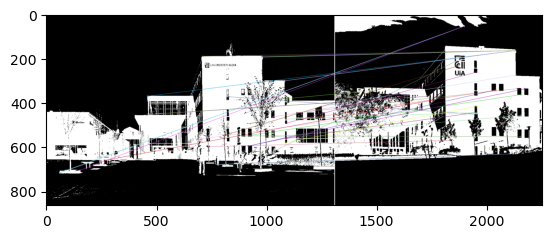

different_1: ORB_BF_UNMATCHED (16 good matches, 0.031s)
Saved match image at: results\orb_results\different_1_orb_bf_unmatched.png
different_10: ORB_BF_UNMATCHED (20 good matches, 0.016s)
Saved match image at: results\orb_results\different_10_orb_bf_unmatched.png
different_2: ORB_BF_UNMATCHED (4 good matches, 0.014s)
Saved match image at: results\orb_results\different_2_orb_bf_unmatched.png
different_3: ORB_BF_UNMATCHED (7 good matches, 0.014s)
Saved match image at: results\orb_results\different_3_orb_bf_unmatched.png
different_4: ORB_BF_UNMATCHED (11 good matches, 0.016s)
Saved match image at: results\orb_results\different_4_orb_bf_unmatched.png
different_5: ORB_BF_UNMATCHED (4 good matches, 0.014s)
Saved match image at: results\orb_results\different_5_orb_bf_unmatched.png
different_6: ORB_BF_UNMATCHED (7 good matches, 0.013s)
Saved match image at: results\orb_results\different_6_orb_bf_unmatched.png
different_7: ORB_BF_UNMATCHED (7 good matches, 0.015s)
Saved match image at: results\

<Figure size 600x500 with 0 Axes>

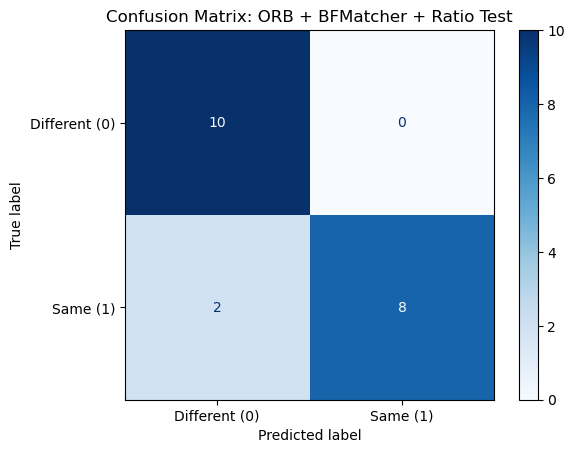

different: ORB_BF_MATCHED (29 good matches, 0.058s)
Saved match image at: results\orb_results\different_orb_bf_matched.png
same: ORB_BF_MATCHED (35 good matches, 0.061s)
Saved match image at: results\orb_results\same_orb_bf_matched.png

Processed 2 pairs
Total wall time: 0.163s | avg per pair: 0.082s
Total CPU time : 0.250s | avg per pair: 0.125s
Perf log saved to: results\orb_results\ORB_perf_log.csv


<Figure size 600x500 with 0 Axes>

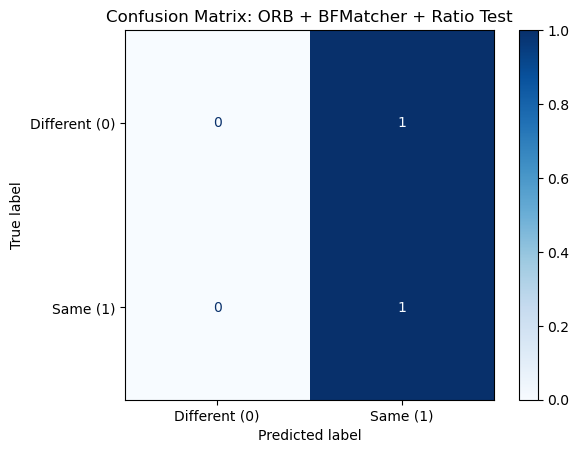

In [4]:
# Quick visual test
_, img = compare_images_orb(r"data\data_UiA\same\UiA front1.png", r"data\data_UiA\same\UiA front3.jpg")
usable_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(usable_img)
plt.show()

# Process the data_check dataset and display confusion matrix
process_dataset_orb(data_path_samples, orb_results_path)
# Process the data_UiA dataset and display confusion matrix
process_dataset_orb(data_path_UiA, orb_results_path)

### Methode 2: SIFT Feature Detection & Matching

The second pipeline uses **SIFT (Scale-Invariant Feature Transform)**, a robust feature detector/descriptor designed to handle changes in scale, rotation, and moderate illumination/affine variations. SIFT typically offers **stronger matching accuracy** than ORB on challenging textures (e.g., fingerprints), albeit at a **higher computational cost**.

**General SIFT workflow:**
1. Preprocess the image (grayscale; optional light blur for denoising).
2. Detect keypoints and compute floating-point descriptors with SIFT.
3. Match descriptors using a distance metric suitable for SIFT (e.g., **L2** via `cv2.BFMatcher(NORM_L2)`).
4. Apply the **Lowe ratio test** to reject ambiguous correspondences.
5. Aggregate “good” matches as a proxy for similarity and evaluate performance (CPU time and counts).

**Why SIFT here?**
- Often **more accurate** and stable across varying viewpoints and subtle texture differences.
- Good fit for **fingerprint ridges** where local gradients dominate the pattern.
- Typically **slower** and more resource-intensive than ORB.

As with the ORB pipeline, we keep the **core flow unchanged** and focus on structure, documentation, and timing-based performance logging. Some preprocessing parameters (e.g., light blurring) may be adjusted to better suit the fingerprint and UiA datasets.

In [5]:
# --- Adjustable parameters ---

SIFT_NFEATURES = 1000          # ADJUSTABLE: maximum number of SIFT keypoints
RATIO_TEST_SIFT = 0.75         # ADJUSTABLE: Lowe's ratio threshold (typical 0.6–0.85)
MATCH_THRESHOLD_SIFT = 24      # ADJUSTABLE: decision threshold on #good matches
BLUR_BEFORE_THRESHOLD = False  # ADJUSTABLE: small blur before thresholding
BLUR_KERNEL = (3, 3)           # ADJUSTABLE: Gaussian blur kernel

# FLANN settings for SIFT (float descriptors, KD-Tree)
SIFT_FLANN_TREES = 5           # ADJUSTABLE: KD-tree count
SIFT_FLANN_CHECKS = 50         # ADJUSTABLE: search checks
KNN_K = 2                      # (NOT) ADJUSTABLE: need k=2 for ratio test

In [6]:
# ============================================================
# SIFT PIPELINE: Feature detection, description & matching
# ============================================================

def preprocess_image_sift(image_path):
    """
    Read an image and prepare it for SIFT feature extraction.

    Parameters
    ----------
    image_path : str
        Path to the input image.

    Returns
    -------
    img_gray : np.ndarray
        Grayscale image used for SIFT detection. (Optional) blur may be applied.
    """
    # --- Load as grayscale (single channel) ---
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    # --- Optional: blur before thresholding to stabilize Otsu on noisy inputs ---
    # Controlled via global flags/params: BLUR_BEFORE_THRESHOLD, BLUR_KERNEL
    if BLUR_BEFORE_THRESHOLD:
        img = cv2.GaussianBlur(img, BLUR_KERNEL, 0) # ADJUSTABLE: kernel size

    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img_bin

# ------------------------------------------------------------
# Pairwise comparison using SIFT features
# ------------------------------------------------------------
def compare_images_sift(img1_path, img2_path):
    """
    Compare two images by SIFT features and return the number of good matches and a visualization.

    Pipeline:
      1) Preprocess (grayscale -> threshold to binary).
      2) Detect SIFT keypoints + float descriptors.
      3) FLANN (KD-Tree) KNN matching (k=2).
      4) Lowe's ratio test to keep only unambiguous matches.
      5) Return the count of good matches and a drawn match image.

    Parameters
    ----------
    img1_path : str
        Path to the first image.
    img2_path : str
        Path to the second image.

    Returns
    -------
    match_count : int
        Number of "good" matches after the ratio test.
    match_img : np.ndarray or None
        Visualization image with matched keypoints drawn (None if nothing to draw).
    """
    # --- Preprocess both images (grayscale) ---
    img1 = preprocess_image_sift(img1_path)
    img2 = preprocess_image_sift(img2_path)

    # Initialize SIFT detector
    sift = cv2.SIFT_create(nfeatures=SIFT_NFEATURES)  # ADJUSTABLE: number of keypoints
 
    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    if des1 is None or des2 is None or len(kp1) == 0 or len(kp2) == 0:
        return 0, None
    
    # Ensure float32 for FLANN (SIFT already returns float32, but be safe)
    if des1.dtype != np.float32:
        des1 = des1.astype(np.float32)
    if des2.dtype != np.float32:
        des2 = des2.astype(np.float32)
 
    # FLANN parameters (KD-tree for SIFT)
    index_params = dict(algorithm=1, trees=SIFT_FLANN_TREES)        # ADJUSTABLE: number of trees
    search_params = dict(checks=SIFT_FLANN_CHECKS)                  # ADJUSTABLE: number of checks
    flann = cv2.FlannBasedMatcher(index_params, search_params)
 
    # KNN Match
    matches = flann.knnMatch(des1, des2, k=KNN_K)  # (ADJUSTABLE): KNN_K must be 2 for ratio test
 
    # Apply Lowe's ratio test (keep only good matches)
    good_matches = [
        p[0] for p in matches
        if len(p) >= 2 and p[0].distance < RATIO_TEST_SIFT * p[1].distance  # ADJUSTABLE: ratio test
    ]
 
    # Draw only good matches
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return len(good_matches), match_img

# ------------------------------------------------------------
# Batch processing over a labeled dataset
# ------------------------------------------------------------
def process_dataset_sift(dataset_path, results_folder):
    """
    Process a labeled dataset structured as:
        dataset_path/
        ├─ <folder_1>  # folder name contains 'same' or 'different'
        │   ├─ image_a.(tif|png|jpg|jpeg|bmp)
        │   └─ image_b.(tif|png|jpg|jpeg|bmp)
        ├─ <folder_2>
        └─ ...

    For each subfolder (must contain exactly 2 images), compare the two images,
    predict "same" (1) or "different" (0) based on the number of good matches,
    save the visualization, and finally plot the confusion matrix across ALL pairs.

    Additionally, this function records SIMPLE performance metrics for the entire
    end-to-end pipeline:
    - Per-pair wall time (seconds) via time.perf_counter()
    - Per-pair CPU time (seconds) via time.process_time()
    - Total/average wall & CPU times printed at the end

    A CSV log is written to:  <results_folder>/SIFT_perf_log.csv
    with columns:
    folder, img1, img2, match_count, wall_time_s, cpu_time_s

    Parameters
    ----------
    dataset_path : str
        Root directory that contains labeled subfolders.
    results_folder : str
        Output directory for match visualization images and SIFT_perf_log.csv.

    Returns
    -------
    None
        Displays a confusion matrix for ALL processed pairs and prints a short
        performance summary (totals and averages).

    Notes
    -----
    - The performance numbers cover the full pipeline per pair:
      load → preprocess → SIFT detect/describe → FLANN KNN match → ratio test → (draw) → decision.
    - The CSV can be used to compute additional statistics outside this function.
    """
    # --- Decision threshold (global) for classifying "same" vs "different" ---
    threshold = MATCH_THRESHOLD_SIFT  # ADJUSTABLE decision threshold
    y_true = []  # True labels (1 for same, 0 for different)
    y_pred = []  # Predicted labels
 
    # Ensure output directory exists
    os.makedirs(results_folder, exist_ok=True)

    # Performance logging setup (CSV)
    perf_csv = os.path.join(results_folder, "SIFT_perf_log.csv")
    perf_rows = [("folder", "img1", "img2", "match_count",
                  "wall_time_s", "cpu_time_s")]

    # --- Total timers for overall runtime stats ---
    total_wall_start = perf_counter()
    total_cpu_start  = process_time()
    
    # Iterate over labeled subfolders
    for folder in sorted(os.listdir(dataset_path)):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a valid directory
            # Collect exactly two image files with supported extensions
            image_files = [
                f for f in os.listdir(folder_path)
                if os.path.splitext(f)[1].lower() in ('.tif', '.png', '.jpg', '.jpeg', '.bmp')
            ]
            if len(image_files) != 2:
                print(f"Skipping {folder}, expected 2 images but found {len(image_files)}")
                continue # Skip if the folder doesn't have exactly 2 images

            image_files.sort()  # Sort to ensure consistent order
            img1_path = os.path.join(folder_path, image_files[0])
            img2_path = os.path.join(folder_path, image_files[1])

            # --- Per-pair timers (wall & CPU) ---
            t0_wall = perf_counter()
            t0_cpu  = process_time()

            # SIFT comparison on this pair
            match_count, match_img = compare_images_sift(img1_path, img2_path)

            # --- Per-pair elapsed times ---
            wall_dt = perf_counter() - t0_wall
            cpu_dt  = process_time() - t0_cpu
 
            # Determine the ground truth
            actual_match = 1 if "same" in folder.lower() else 0  # 1 for same, 0 for different
            y_true.append(actual_match)
 
            # Decision based on good matches count
            predicted_match = 1 if match_count >= threshold else 0
            y_pred.append(predicted_match)

            result = "sift_flann_matched" if predicted_match == 1 else "sift_flann_unmatched"
            print(f"{folder}: {result.upper()} ({match_count} good matches, {wall_dt:.3f}s)")

            # Save visualization image for this pair in results folder
            if match_img is not None:
                match_img_filename = f"{folder}_{result}.png"
                match_img_path = os.path.join(results_folder, match_img_filename)
                cv2.imwrite(match_img_path, match_img)
                print(f"Saved match image at: {match_img_path}")

            # --- Append one row to the perf log (as strings for csv safety) ---
            perf_rows.append((folder, image_files[0], image_files[1],
                              match_count, f"{wall_dt:.6f}", f"{cpu_dt:.6f}"))

    # --- Compute total durations ---
    total_wall = perf_counter() - total_wall_start
    total_cpu  = process_time() - total_cpu_start

    # --- Append to CSV (create or extend) ---
    with open(perf_csv, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(perf_rows)

    # --- Print overall summary ---
    pairs = len(perf_rows) - 1
    if pairs > 0:
        avg_wall = total_wall / pairs
        avg_cpu  = total_cpu / pairs
        print(f"\nProcessed {pairs} pairs (SIFT)")
        print(f"Total wall time: {total_wall:.3f}s | avg per pair: {avg_wall:.3f}s")
        print(f"Total CPU time : {total_cpu:.3f}s | avg per pair: {avg_cpu:.3f}s")
        print(f"Perf log saved to: {perf_csv}")

    # Confusion matrix over ALL processed pairs
    if len(y_true) == 0:
        print("No labeled pairs processed. Skipping confusion matrix.")
        return

    # Compute and display confusion matrix
    labels = ["Different (0)", "Same (1)"]
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix: SIFT + FLANN + Ratio Test")
    plt.show()

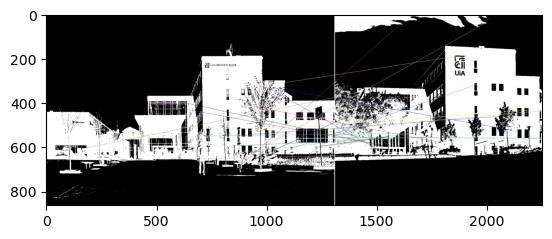

different_1: SIFT_FLANN_UNMATCHED (19 good matches, 0.079s)
Saved match image at: results\sift_results\different_1_sift_flann_unmatched.png
different_10: SIFT_FLANN_UNMATCHED (15 good matches, 0.080s)
Saved match image at: results\sift_results\different_10_sift_flann_unmatched.png
different_2: SIFT_FLANN_UNMATCHED (18 good matches, 0.078s)
Saved match image at: results\sift_results\different_2_sift_flann_unmatched.png
different_3: SIFT_FLANN_UNMATCHED (15 good matches, 0.093s)
Saved match image at: results\sift_results\different_3_sift_flann_unmatched.png
different_4: SIFT_FLANN_MATCHED (25 good matches, 0.085s)
Saved match image at: results\sift_results\different_4_sift_flann_matched.png
different_5: SIFT_FLANN_UNMATCHED (12 good matches, 0.074s)
Saved match image at: results\sift_results\different_5_sift_flann_unmatched.png
different_6: SIFT_FLANN_UNMATCHED (21 good matches, 0.068s)
Saved match image at: results\sift_results\different_6_sift_flann_unmatched.png
different_7: SIFT_FLAN

<Figure size 600x500 with 0 Axes>

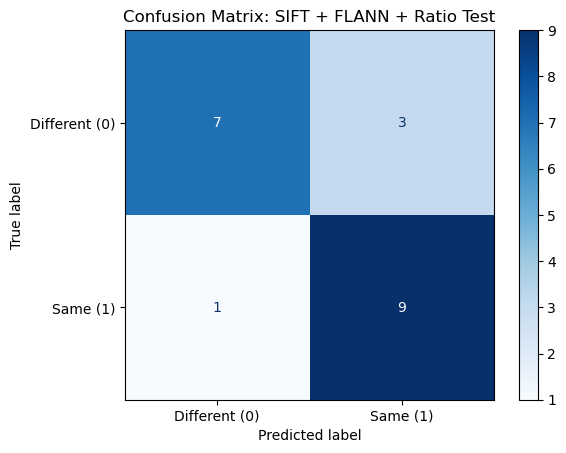

different: SIFT_FLANN_MATCHED (24 good matches, 0.261s)
Saved match image at: results\sift_results\different_sift_flann_matched.png
same: SIFT_FLANN_MATCHED (26 good matches, 0.287s)
Saved match image at: results\sift_results\same_sift_flann_matched.png

Processed 2 pairs (SIFT)
Total wall time: 0.591s | avg per pair: 0.296s
Total CPU time : 1.188s | avg per pair: 0.594s
Perf log saved to: results\sift_results\SIFT_perf_log.csv


<Figure size 600x500 with 0 Axes>

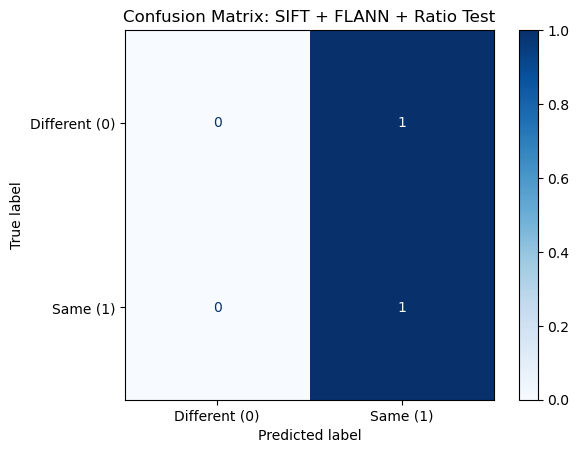

In [7]:
# Quick visual test
_, img = compare_images_sift(r"data\data_UiA\same\UiA front1.png", r"data\data_UiA\same\UiA front3.jpg")
usable_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(usable_img)
plt.show()

# Process the data_check dataset and display confusion matrix
process_dataset_sift(data_path_samples, sift_results_path)
# Process the data_UiA dataset and display confusion matrix
process_dataset_sift(data_path_UiA, sift_results_path)

### Final Summary & Interpretation

Below we summarize **accuracy and class-wise metrics** derived from our confusion matrices, and discuss **CPU-only performance**.  
Notation: rows = *true* label, columns = *predicted* label. Positive class is **Same (1)**.

---

#### 1) Fingerprints

##### ORB (BFMatcher + Hamming + Ratio Test)
Confusion Matrix:
$$\begin{bmatrix} 10 & 0 \\ 2 & 8 \end{bmatrix}$$
- **Accuracy:** (10 + 8) / 20 = **0.90**
- **Precision (Same=1):** 8 / (8 + 0) = **1.00**
- **Recall (Same=1):** 8 / (8 + 2) = **0.80**
- **Specificity (Different=0):** 10 / (10 + 0) = **1.00**

**Takeaway:** Very few false matches (FP=0) and overall strongest accuracy here.

##### SIFT (FLANN + Ratio Test)
Confusion Matrix:
$$\begin{bmatrix} 7 & 3 \\ 1 & 9 \end{bmatrix}$$
- **Accuracy:** (7 + 9) / 20 = **0.80**
- **Precision (Same=1):** 9 / (9 + 3) = **0.75**
- **Recall (Same=1):** 9 / (9 + 1) = **0.90**
- **Specificity (Different=0):** 7 / (7 + 3) = **0.70**

**Takeaway:** Better **recall** than ORB (finds more true “Same” pairs), but more **false positives** and lower overall accuracy than ORB on this set.

**Conclusion for fingerprints:**  
Given our results, **ORB outperforms SIFT in overall accuracy (90% vs. 80%)** and delivers perfect precision/specificity on this dataset, while SIFT provides higher recall but at the cost of more false matches.

---

#### 2) UiA Images (Logos)

##### ORB
Confusion Matrix:
$$\begin{bmatrix} 0 & 1 \\ 0 & 1 \end{bmatrix}$$
- **Accuracy:** (0 + 1) / 2 = **0.50**
- **Precision (Same=1):** 1 / (1 + 1) = **0.50**
- **Recall (Same=1):** 1 / (1 + 0) = **1.00**
- **Specificity (Different=0):** 0 / (0 + 1) = **0.00**

##### SIFT
Confusion Matrix:
$$\begin{bmatrix} 0 & 1 \\ 0 & 1 \end{bmatrix}$$
*(same as ORB)*  
- **Accuracy:** **0.50**
- **Precision (Same=1):** **0.50**
- **Recall (Same=1):** **1.00**
- **Specificity (Different=0):** **0.00**

**Conclusion for UiA:**  
On this very small sample (n=2), **both methods behave identically** (50% accuracy). With no advantage in accuracy, **ORB** is preferable **for speed**.

---

#### 3) CPU-Only Performance
- We compare **CPU wall/CPU process time**.  
- In general, **ORB** is faster than **SIFT** (binary descriptors + Hamming vs. float + FLANN).  
- Combined with the fingerprint results above, **ORB is the more efficient pipeline** here (better accuracy *and* lower runtime).  
- For UiA, since accuracy ties, **ORB** still wins on **speed**.

---

#### 4) Conclusion & Recommendations
- **Fingerprints:** Choose **ORB** — higher accuracy on your set and faster CPU execution.  
  - Use **SIFT** only if maximizing **recall** matters more than avoiding false matches.
- **UiA logos:** Both are equivalent in accuracy on your tiny sample; pick **ORB** for speed.

*Note:* These conclusions are specific to the provided datasets and thresholds. Different preprocessing or thresholds may shift the balance.